In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.ensemble import RandomForestClassifier
import matplotlib as plt
from sklearn.cross_validation import train_test_split

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [ ]:
#Read data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sampleSubmission = pd.read_csv("sampleSubmission.csv")

target = 'Cover_Type'

#shuffle train data
train = train.sample(frac=1.0)

In [26]:
#Examine trian data
print train[1:3]
print 'length of train data: ', len(train)
print 'length of test data: ', len(test)
print 'frequency of target variable \n' , train.Cover_Type.value_counts()

        Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
1347  1348       2815      55     18                               120   
7595  7596       2620     146      5                               324   

      Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
1347                             -14                              297   
7595                              75                             1638   

      Hillshade_9am  Hillshade_Noon  Hillshade_3pm     ...      Soil_Type32  \
1347            229             199             97     ...                0   
7595            228             239            145     ...                0   

      Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
1347            0            0            0            0            0   
7595            0            0            0            0            0   

      Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type  
1347            0            0           

In [29]:
IDcol = 'Id'
predictors = [x for x in train.columns if x not in [target, IDcol]]
scaler = StandardScaler()

#standard scaler
train[predictors] = scaler.fit_transform(train[predictors])
test[predictors] = scaler.transform(test[predictors])

In [66]:
def modelfit(alg, X, Y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X,Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, Y, cv=cv_folds, scoring='f1_weighted')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(Y.values, dtrain_predictions)
    print metrics.classification_report(Y.values, dtrain_predictions)
    
    if performCV:
        print "CV (f1) Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % \
        (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, list(X_fit.columns.values)).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')

In [58]:
X_fit, X_eval, y_fit, y_eval= train_test_split(train[predictors], train[target], test_size=0.3)


Model Report
Accuracy : 0.8442
             precision    recall  f1-score   support

          1       0.79      0.78      0.79      1551
          2       0.81      0.66      0.73      1503
          3       0.81      0.78      0.79      1489
          4       0.93      0.98      0.96      1522
          5       0.83      0.94      0.88      1540
          6       0.80      0.82      0.81      1503
          7       0.92      0.96      0.94      1476

avg / total       0.84      0.84      0.84     10584

CV (f1) Score : Mean - 0.7826579 | Std - 0.008180449 | Min - 0.7738007 | Max - 0.7935189


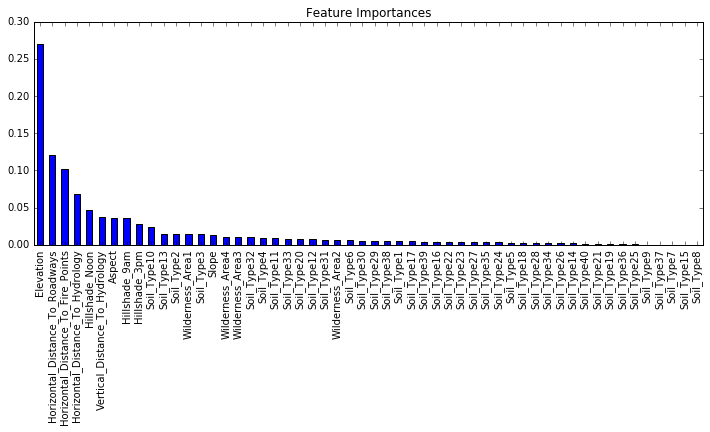

In [68]:
#Let's try GBM
#Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_fit, y_fit)

In [69]:
#Evaluate on development data
preds = gbm0.predict(X_eval)
print "Accuracy : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)

Accuracy : 0.7917
             precision    recall  f1-score   support

          1       0.72      0.70      0.71       609
          2       0.74      0.58      0.65       657
          3       0.74      0.70      0.72       671
          4       0.89      0.95      0.92       638
          5       0.78      0.92      0.84       620
          6       0.75      0.75      0.75       657
          7       0.90      0.94      0.92       684

avg / total       0.79      0.79      0.79      4536




Model Report
Accuracy : 0.9941
             precision    recall  f1-score   support

          1       0.98      0.99      0.99      1551
          2       0.99      0.98      0.99      1503
          3       0.99      1.00      0.99      1489
          4       1.00      1.00      1.00      1522
          5       1.00      1.00      1.00      1540
          6       1.00      0.99      0.99      1503
          7       1.00      1.00      1.00      1476

avg / total       0.99      0.99      0.99     10584

CV (f1) Score : Mean - 0.8091946 | Std - 0.005254971 | Min - 0.800785 | Max - 0.8150622
----------------Development Data Report----------------------
Accuracy : 0.8236
             precision    recall  f1-score   support

          1       0.70      0.73      0.72       609
          2       0.74      0.65      0.69       657
          3       0.78      0.80      0.79       671
          4       0.90      0.96      0.93       638
          5       0.89      0.92      0.91       620
 

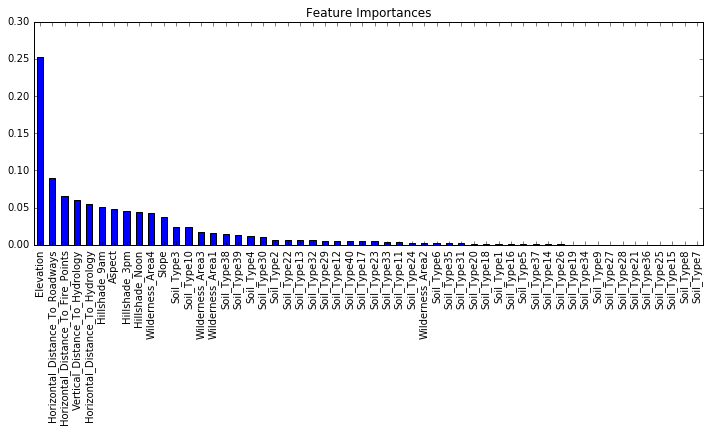

In [74]:
#let's try Random Forest model

#Choose all predictors except target & IDcols
rfc = RandomForestClassifier(random_state=10)
modelfit(rfc, X_fit, y_fit)
#Evaluate on development data
print "----------------Development Data Report----------------------"
preds = rfc.predict(X_eval)
print "Accuracy : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)

In [75]:
#Submission of test values
preds = rfc.predict(test[predictors])
submission = pd.DataFrame({"Id":test[IDcol], "Cover_Type":preds})
submission.to_csv("submission.csv", index=False)